In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import pickle as pk

### Arguments

In [49]:
subject = 'F'
layer = 1
context_length = 1
# voxels_options = ['ALL', 'ALLROI', 'POSTTEMP', 'ANTTEMP', 'ANGULARG', 'IFG', 'MFG', 'IFGORB', 'PCINGULATE', 'DMPFC']
voxels_type = 'ALLROI'

In [3]:
def get_X_Y(metrics1, metrics2, subject, voxels_type):
    X = np.nanmean(metrics1, axis=0)
    Y = np.nanmean(metrics2, axis=0)

    X[np.where(np.isnan(X) == 1)] = 0
    Y[np.where(np.isnan(Y) == 1)] = 0

    rois = np.load('../HP_subj_roi_inds.npy', allow_pickle=True)

    if voxels_type != 'ALL':
        X = X[np.where(rois.item()[subject]['all'] == 1)[0]]
        Y = Y[np.where(rois.item()[subject]['all'] == 1)[0]]
        if voxels_type != 'ALLROI':
            if voxels_type == 'POSTTEMP':
                mask = rois.item()[subject]['PostTemp'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'ANTTEMP':
                mask = rois.item()[subject]['AntTemp'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'ANGULARG':
                mask = rois.item()[subject]['AngularG'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'IFG':
                mask = rois.item()[subject]['IFG'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'MFG':
                mask = rois.item()[subject]['MFG'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'IFGORB':
                mask = rois.item()[subject]['IFGorb'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'PCINGULATE':
                mask = rois.item()[subject]['pCingulate'][np.where(rois.item()[subject]['all'] > 0)[0]]
            elif voxels_type == 'DMPFC':
                mask = rois.item()[subject]['dmpfc'][np.where(rois.item()[subject]['all'] > 0)[0]]
            X = np.ma.masked_equal(mask * X, 0).compressed()
            Y = np.ma.masked_equal(mask * Y, 0).compressed()
    return X, Y

# Correlation Plots

In [ ]:
model1 = 'linear'
model2 = 'mlp_allvoxels_noweightdecay-sharedhidden'

In [ ]:
output_path = 'encoder_preds/maxvoxels/predict_{}_with_bert_layer_{}_len_{}_encoder_{}.npy'
output1 = np.load(output_path.format(subject, layer, context_length, model1), allow_pickle=True)
output2 = np.load(output_path.format(subject, layer, context_length, model2), allow_pickle=True)
corrs1 = output1.item()['corrs_t']
corrs2 = output2.item()['corrs_t']

In [ ]:
def plot_correlations(X, Y, subject, voxels_type, x_label, y_label):
    delete_indices = np.where((np.isnan(X) == 1) | (np.isnan(Y) == 1))
    X = np.delete(X, delete_indices, 0)
    Y = np.delete(Y, delete_indices, 0)

    # Best fit line data
    X_above_zero = X[(X > 0) | (Y > 0)]
    Y_above_zero = Y[(X > 0) | (Y > 0)]
    xmin = X_above_zero.min()
    xmax = X_above_zero.max()
    slope, y_intercept = np.polyfit(X_above_zero, Y_above_zero, deg=1)
    x_0, y_0, x_1, y_1 = xmin, slope*xmin+y_intercept, xmax, slope*xmax+y_intercept

    fig, ax = plt.subplots()
    
    ax.scatter(X, Y)
    bf_line = mlines.Line2D([x_0, x_1], [y_0, y_1], color='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(bf_line)
    ax.add_line(line)

    plt.title('{} vs {} Correlations: Subject {} - {} Voxels'.format(x_label, y_label, subject, voxels_type))
    plt.xlabel('{} corrs'.format(x_label))
    plt.ylabel('{} corrs'.format(y_label))
    plt.xlim(-0.25, 0.5)
    plt.ylim(-0.25, 0.5)
    plt.show()

In [ ]:
X, Y = get_X_Y(corrs1, corrs2, subject, voxels_type)

In [ ]:
output2.item()['train_losses_t'].shape

In [ ]:
plot_correlations(X, Y, subject, voxels_type, model1, model2)

# Accuracy Plots

In [20]:
model1 = 'linear'
model2 = 'mlp_allvoxels_noweightdecay-sharedhidden'
acc_type = 'noneighborhood' # or 'neighborhood'

In [21]:
accs_path = 'final_accs/maxvoxels/{}/{}_with_bert_layer_{}_len_{}_encoder_{}_accs.pkl'
accs1 = pk.load(open(accs_path.format(acc_type, subject, layer, context_length, model1), 'rb'))
accs2 = pk.load(open(accs_path.format(acc_type, subject, layer, context_length, model2), 'rb'))

In [46]:
def plot_accuracies(X, Y, subject, voxels_type, x_label, y_label):
    delete_indices = np.where((np.isnan(X) == 1) | (np.isnan(Y) == 1))
    X = np.delete(X, delete_indices, 0)
    Y = np.delete(Y, delete_indices, 0)

    # Best fit line data
    X_above_half = X[(X > 0.5) | (Y > 0.5)]
    Y_above_half = Y[(X > 0.5) | (Y > 0.5)]
    xmin = X_above_half.min()
    xmax = X_above_half.max()
    slope, y_intercept = np.polyfit(X_above_half, Y_above_half, deg=1)
    x_0, y_0, x_1, y_1 = xmin, slope*xmin+y_intercept, xmax, slope*xmax+y_intercept

    fig, ax = plt.subplots()
    ax.scatter(X, Y)

    bf_line = mlines.Line2D([x_0, x_1], [y_0, y_1], color='black')
    line = mlines.Line2D([0, 1], [0, 1], color='red')
    transform = ax.transAxes
    # bf_line.set_transform(transform)
    line.set_transform(transform)

    ax.add_line(bf_line)
    ax.add_line(line)

    plt.title('{} vs {} Accuracies (No Neighborhood): Subject {} - {} Voxels'.format(x_label, y_label, subject, voxels_type))
    plt.xlabel('{} accs'.format(x_label))
    plt.ylabel('{} accs'.format(y_label))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.figure(figsize=(1000,1000))
    plt.show()

In [50]:
X, Y = get_X_Y(accs1, accs2, subject, voxels_type)

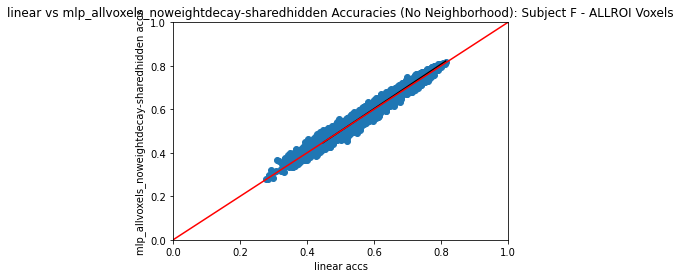

<Figure size 72000x72000 with 0 Axes>

In [51]:
plot_accuracies(X, Y, subject, voxels_type, model1, model2)